# Feature Engineering for Taxi Trips Data

In this notebook, our primary focus will be on the Feature Engineering for the taxi trips data. Feature engineering is an essential step in the data preprocessing pipeline that can help algorithms to better understand the underlying patterns in the data, potentially leading to enhanced model performance.

Having already cleaned and formatted our dataset in the "Data Preparation" notebook, we'll now create and extract more sophisticated features to further enrich our dataset, making it ready for subsequent tasks like clustering, predictive modeling, etc.

## Importing Necessary Libraries
We start by importing necessary libraries, each serving a specific purpose in our data preparation process:
- `numpy` and `pandas`: Essential libraries for data handling and manipulation.
- `datetime`: Module for manipulating dates and times.
- `geopandas`: A tool to handle geographic data.
- `seaborn` and `matplotlib.pyplot`: Libraries for data visualization.
- `gc`: Python's garbage collector, which helps manage memory.
- `pickle`: A module for serializing and deserializing Python objects, useful for saving and loading data.
- `google.colab`: A module that allows us to interact with Google Colab, including reading data from Google Drive and adjusting the display of dataframes.


In [1]:
!pip install h3

import h3
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import shape


import gc
import pickle

from google.colab import drive, data_table
data_table.enable_dataframe_formatter()

from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In this section, we'll mount Google Drive to facilitate data import—a crucial step when operating within Google Colab, as it enables access to files stored on Google Drive. The data, stored as a pickle file (trips_2013_extended), is a native Python serialization format and will be loaded into a Pandas DataFrame. This data contains the cleaned and processed taxi trips, forming the backbone of our forthcoming analysis.

Additionally, we will load several geojson files that provide context about Chicago's census tracts, points of interest, and city boundaries.


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the pickle file
pickle_file_path = '/content/drive/MyDrive/3A23/Data/trips_2013_cleaned.pkl'

# Load the Pickle file into a Pandas DataFrame
with open(pickle_file_path, 'rb') as file:
    df_trips = pickle.load(file)

# Import POI related geojson files
poi_paths = [
    '/content/drive/MyDrive/3A23/Data/tourism_polygon.geojson',
    '/content/drive/MyDrive/3A23/Data/entertainment_polygon.geojson',
    '/content/drive/MyDrive/3A23/Data/airport_polygon.geojson',
    '/content/drive/MyDrive/3A23/Data/public_building_polygon.geojson'
]
gdfs = [gpd.read_file(path) for path in poi_paths]
gdfs[2] = gdfs[2].iloc[[0, 1]]  # Retain primary airports, exclude gates
gdf = pd.concat(gdfs, ignore_index=True)

# Load census tract related geojson file
census_tract_boundaries = gpd.read_file('/content/drive/MyDrive/3A23/Data/chicago_census_tracts.geojson')

# Load and process city boundaries related geojson file
city = gpd.read_file('/content/drive/MyDrive/3A23/Data/boundaries_city.geojson')
city_json = json.loads(city.to_json())
city_poly = city_json["features"][0]


Mounted at /content/drive


## Adding Distance Features

Trips in relation to Points of Interest (POIs) can provide valuable insights into the potential purposes behind them. For instance, trips starting or ending near airports or business districts could suggest business trips. To capture this, we'll compute two new features:
- 'min_distance_to_poi_start': The shortest distance from the start location of a trip to any of the POIs.
- 'min_distance_to_poi_end': The shortest distance from the end location of a trip to any of the POIs.

Such distance-based features might help us identify clusters of trips with similar purposes or characteristics.

In [3]:
'''
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Get the centroid of each polygon and convert to list of tuples (latitude, longitude)
points_of_interest = [(pt[1], pt[0]) for pt in [list(polygon.centroid.coords)[0] for polygon in gdf['geometry']]]

# Convert latitude and longitude to radians
points_of_interest_rad = [np.array([radians(pt[0]), radians(pt[1])]) for pt in points_of_interest]

# Function to calculate minimum haversine distance
def min_haversine(lat, lon, points_of_interest_rad):
    loc_rad = np.array([radians(lat), radians(lon)])
    return min(haversine_distances([loc_rad], points_of_interest_rad)[0]) * 6371000/1000 # convert to kilometers

# Set chunk size due to limited RAM
chunk_size = 100000
chunks = [x for x in range(0, df_trips.shape[0], chunk_size)]

# Placeholder for results
min_distance_to_poi_start = pd.Series(dtype='float64')
min_distance_to_poi_end = pd.Series(dtype='float64')

# Loop over chunks and calculate min_distance_to_poi for each chunk
for i in range(len(chunks)-1):

    display(f'Processing chunk {i+1}/{len(chunks)-1}') # Progress tracker
    clear_output(wait=True)

    df_chunk = df_trips.iloc[chunks[i]:chunks[i+1]]
    min_distance_chunk_start = df_chunk.apply(lambda row: min_haversine(row['start_lat'], row['start_long'], points_of_interest_rad), axis=1)
    min_distance_to_poi_start = pd.concat([min_distance_to_poi_start, min_distance_chunk_start])
    min_distance_chunk_end = df_chunk.apply(lambda row: min_haversine(row['end_lat'], row['end_long'], points_of_interest_rad), axis=1)
    min_distance_to_poi_end = pd.concat([min_distance_to_poi_end, min_distance_chunk_end])

# last chunk
df_chunk = df_trips.iloc[chunks[-1]:]
min_distance_chunk_start = df_chunk.apply(lambda row: min_haversine(row['start_lat'], row['start_long'], points_of_interest_rad), axis=1)
min_distance_to_poi_start = pd.concat([min_distance_to_poi_start, min_distance_chunk_start])
min_distance_chunk_end = df_chunk.apply(lambda row: min_haversine(row['end_lat'], row['end_long'], points_of_interest_rad), axis=1)
min_distance_to_poi_end = pd.concat([min_distance_to_poi_end, min_distance_chunk_end])

# Assign the results back to the dataframe
df_trips['min_distance_to_poi_start'] = min_distance_to_poi_start.values
df_trips['min_distance_to_poi_end'] = min_distance_to_poi_end.values

# Clear RAM
del df_chunk, min_distance_to_poi_start, min_distance_chunk_start, min_distance_to_poi_end, min_distance_chunk_end
gc.collect()
'''

"\nfrom sklearn.metrics.pairwise import haversine_distances\nfrom math import radians\n\n# Get the centroid of each polygon and convert to list of tuples (latitude, longitude)\npoints_of_interest = [(pt[1], pt[0]) for pt in [list(polygon.centroid.coords)[0] for polygon in gdf['geometry']]]\n\n# Convert latitude and longitude to radians\npoints_of_interest_rad = [np.array([radians(pt[0]), radians(pt[1])]) for pt in points_of_interest]\n\n# Function to calculate minimum haversine distance\ndef min_haversine(lat, lon, points_of_interest_rad):\n    loc_rad = np.array([radians(lat), radians(lon)])\n    return min(haversine_distances([loc_rad], points_of_interest_rad)[0]) * 6371000/1000 # convert to kilometers\n\n# Set chunk size due to limited RAM\nchunk_size = 100000\nchunks = [x for x in range(0, df_trips.shape[0], chunk_size)]\n\n# Placeholder for results\nmin_distance_to_poi_start = pd.Series(dtype='float64')\nmin_distance_to_poi_end = pd.Series(dtype='float64')\n\n# Loop over chunks an

## Adding POI Count Features
Continuing our feature engineering process, we introduce 'poi_count_start' and 'poi_count_end'. These features represent the concentration of points of interest at the start and end locations of the trips. We hypothesize that the density of POIs could influence trip patterns and behaviors, making these features potentially useful for our clustering task.


In [4]:
# Reproject the gdf GeoDataFrame to have the same CRS as census_tract_boundaries
gdf_reprojected = gdf.to_crs(census_tract_boundaries.crs)

# For start_census_tract and end_census_tract
for census_tract_col in ['start_census_tract', 'end_census_tract']:
    # Create an empty list to store the corresponding census tract for each polygon
    census_tract_list = []

    # Iterate through each polygon in the gdf_reprojected GeoDataFrame
    for polygon in gdf_reprojected['geometry']:
    # Get the centroid of the polygon
        centroid = polygon.centroid

        # Check which census tract contains the centroid
        mask = census_tract_boundaries.contains(centroid)
        census_tract = census_tract_boundaries[mask]['geoid10'].values
        if len(census_tract) > 0:
            census_tract_list.append(census_tract[0])
        else:
            census_tract_list.append(None)

    # Add the census tract information to the gdf_reprojected GeoDataFrame
    gdf_reprojected['census_tract'] = census_tract_list

    # Drop rows with missing values in 'census_tract' column in gdf_reprojected
    gdf_reprojected.dropna(subset=['census_tract'], inplace=True)

    # Convert 'census_tract' column in gdf_reprojected to int64
    gdf_reprojected['census_tract'] = gdf_reprojected['census_tract'].astype(int)

    # Group by 'census_tract' and count the number of points of interest per census tract
    poi_count_per_tract = gdf_reprojected.groupby('census_tract').size().reset_index(name='poi_count')

    # Merge the poi_count_per_tract back to the df_trips DataFrame
    df_trips = pd.merge(df_trips, poi_count_per_tract, left_on=census_tract_col, right_on='census_tract', how='left')

    # Rename the 'poi_count' column to 'poi_count_start' or 'poi_count_end'
    df_trips.rename(columns={'poi_count': 'poi_count_' + census_tract_col.split('_')[0]}, inplace=True)

    # Fill NA values with 0 in the newly created 'poi_count_start' or 'poi_count_end' column
    df_trips['poi_count_' + census_tract_col.split('_')[0]] = df_trips['poi_count_' + census_tract_col.split('_')[0]].fillna(0)

    # Drop the 'census_tract' column
    df_trips.drop(columns='census_tract', inplace=True)

del census_tract_list, mask, census_tract, gdf_reprojected
gc.collect()

17


We can now create a heatmap to visualize the distribution of Points of Interest (POIs) across different census tracts. This visualization helps us understand the spatial distribution of POIs, which could provide insights into the urban landscape and the characteristics of different neighborhoods.

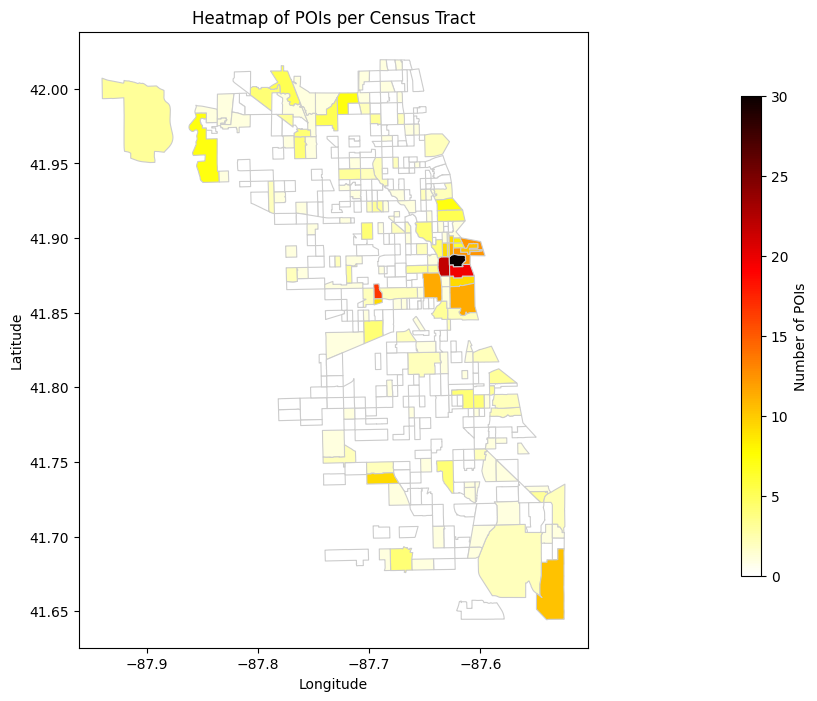

In [5]:
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.ticker import FuncFormatter

# Merge poi_count_per_tract with census_tract_boundaries on the 'census_tract' column
census_tract_boundaries['geoid10'] = census_tract_boundaries['geoid10'].astype('int64')
gdf_heatmap = census_tract_boundaries.merge(poi_count_per_tract, left_on='geoid10', right_on='census_tract')

# Set the column, description, and legend description
column = 'poi_count'
description = 'Heatmap of POIs per Census Tract'
legend_description = 'Number of POIs'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the polygons with color based on the count values
cmap = 'hot_r'
gdf_heatmap.plot(column=column, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')

# Set the title and axes labels
plt.title(description)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create the colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
vmin = 0
vmax = gdf_heatmap[column].max()

# Normalize the colorbar ticks
norm = Normalize(vmin=vmin, vmax=vmax)

# Format the colorbar tick labels as numbers
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')  # Format as comma-separated integers
cbar = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', format=formatter)

# Set the colorbar label
cbar.set_label(legend_description)

# Display the map with the colorbar
plt.show()

## Identifying Airport Trips
Given that airports are significant transportation hubs, we suspect that trips to and from airports might exhibit unique characteristics. Therefore, we introduce a new binary feature, 'airport_trip', to indicate whether a trip is associated with an airport. This feature might reveal specific clusters related to airport commutes.

In [6]:
df_trips['airport_trip'] = ((df_trips['start_census_tract'] == 17031980000) | (df_trips['start_census_tract'] == 17031980100) |
                            (df_trips['end_census_tract'] == 17031980000) | (df_trips['end_census_tract'] == 17031980100)).astype(int)

## Highlighting Special Dates

Special events or celebrations tend to attract large crowds, leading to spikes in transportation demand. Recognizing trips that coincide with these events can unveil unique patterns in the data, potentially aiding the clustering process. With this premise, we mark trips occurring on standout dates in Chicago's 2013 calendar:

- **Saint Patrick's Day Parade**: March 16 (Notably, the Chicago River is dyed green on this day.)
- **Memorial Day Parade**: May 25
- **Chicago Pride Parade**: June 30
- **Taste of Chicago**: July 10 - 14
- **Chicago Air and Water Show**: August 17 - 18
- **Chicago Marathon**: October 13
- **Thanksgiving Day Parade**: November 28
- **Magnificent Mile Lights Festival**: November 23
- **New Year's Eve Celebrations**: December 31

We'll denote these occurrences with the `is_special_date` feature in our dataset.


In [7]:
# Define special dates for 2013 in datetime format
special_dates_2013 = [
    '2013-03-16', # Saint Patrick's Day Parade
    '2013-05-25', # Memorial Day Parade
    '2013-06-30', # Chicago Pride Parade
    '2013-07-10', # Taste of Chicago (Start)
    '2013-07-11', # Taste of Chicago
    '2013-07-12', # Taste of Chicago
    '2013-07-13', # Taste of Chicago
    '2013-07-14', # Taste of Chicago (End)
    '2013-08-17', # Chicago Air and Water Show (Start)
    '2013-08-18', # Chicago Air and Water Show (End)
    '2013-10-13', # Chicago Marathon
    '2013-11-28', # Thanksgiving Day Parade
    '2013-11-23', # Magnificent Mile Lights Festival
    '2013-12-31'  # New Year's Eve Celebrations
]

# Convert special dates list into datetime format
special_dates = pd.to_datetime(special_dates_2013)

# Create a binary column to indicate whether the trip started on a special date
df_trips['is_special_date'] = df_trips['start_time'].dt.floor('D').isin(special_dates).astype(int)


Holidays often impact taxi demand aswell. By incorporating local holiday dates, we can potentially uncover patterns or anomalies in our taxi trip data associated with these specific dates.



In [8]:
# Define local holidays for 2013 in datetime format
holidays_2013 = [
    '2013-01-01', # New Year's Day
    '2013-01-21', # Martin Luther King Jr. Day
    '2013-02-12', # Lincoln's Birthday
    '2013-02-18', # Washington's Birthday
    '2013-03-04', # Casimir Pulaski Day
    '2013-05-27', # Memorial Day
    '2013-07-04', # Independence Day
    '2013-09-02', # Labor Day
    '2013-10-14', # Columbus Day
    '2013-11-11', # Veterans Day
    '2013-11-28', # Thanksgiving Day
    '2013-12-25'  # Christmas Day
]

# Convert holiday list into datetime format
holidays = pd.to_datetime(holidays_2013)

# Create a binary column to indicate whether the trip started on a holiday
df_trips['is_holiday'] = df_trips['start_time'].dt.floor('D').isin(holidays).astype(int)


## Extracting Temporal Features

Temporal aspects can significantly influence transportation demand. Recognizing patterns linked to time - whether it's the difference between weekdays and weekends, specific hours in the day, or even changes across months - is essential for understanding taxi demand. To capture these nuances, we'll derive several time-related features from each trip's start time. This will allow us to grasp nuances like peak hours, weekend trends, and potential seasonal variations.


In [9]:
# Extract hour from the start time
df_trips["hour"] = df_trips["start_time"].dt.hour

# Extract day without time for clarity in analysis
df_trips['day'] = df_trips['start_time'].dt.date

# Determine the day of the week (Monday=0, Sunday=6)
df_trips["week_day"] = df_trips["start_time"].dt.weekday

# Categorize hour of the day into different parts for better understanding
df_trips['part_of_day'] = df_trips['hour'].apply(lambda hour: 'Early Morning' if 0 <= hour < 5 else
                                                 'Morning' if 5 <= hour < 11 else
                                                 'Afternoon' if 11 <= hour < 16 else
                                                 'Evening' if 16 <= hour < 21 else
                                                 'Night')

# Check if the day is a weekend
df_trips['is_weekend'] = df_trips['week_day'].apply(lambda x: 1 if x >= 5 else 0)

# Extract the month from the start time
df_trips['month'] = df_trips['start_time'].dt.month


## Fare Efficiency Features

To evaluate the economic aspect of the taxi trips, we're introducing metrics that capture fare efficiency: 'cost per minute' and 'cost per mile'. These metrics can provide insights into the cost-effectiveness of the taxi trips, offering a perspective on how fares relate to the time and distance of the trips. Uncovering patterns related to fare efficiency might lead us to identify distinct clusters of trips that exhibit similar economic behaviors.


In [10]:
# Calculate cost per minute based on fare and duration
df_trips['cost_per_minute'] = df_trips['fare'] / df_trips['duration']

# Calculate cost per kilometer based on fare and distance
df_trips['cost_per_km'] = df_trips['fare'] / df_trips['distance']


## H3-Uber Discretization

To facilitate spatial analysis, we employ the H3-Uber (https://h3geo.org/docs/) library to discretize Chicago. We initially visualize the city with diverse hexagon resolutions. At a hexagon resolution of 7, Chicago gets partitioned into 118 hexagons, each having an edge length of approximately 1.4 kilometers (https://h3geo.org/docs/core-library/restable/). This granularity is congruent with our objective. For comprehensive analysis, resolutions 6 and 8 are also incorporated. Resolutions below 6 or above 8 are deemed either too broad or too fine-grained to be of any actionable significance for our study.


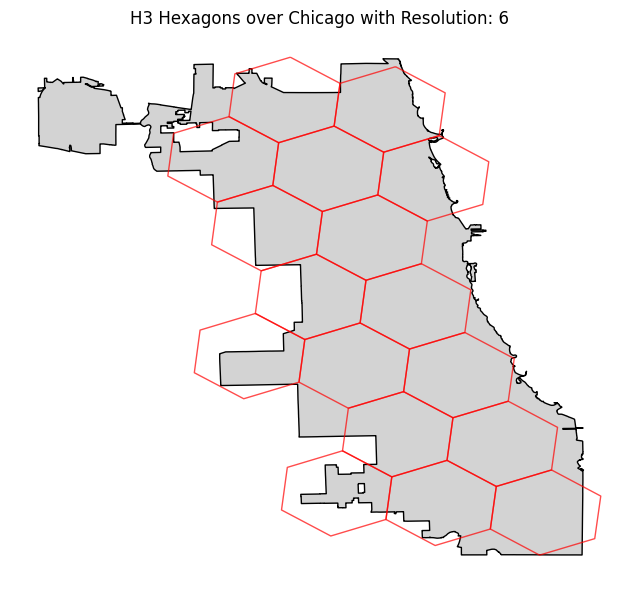

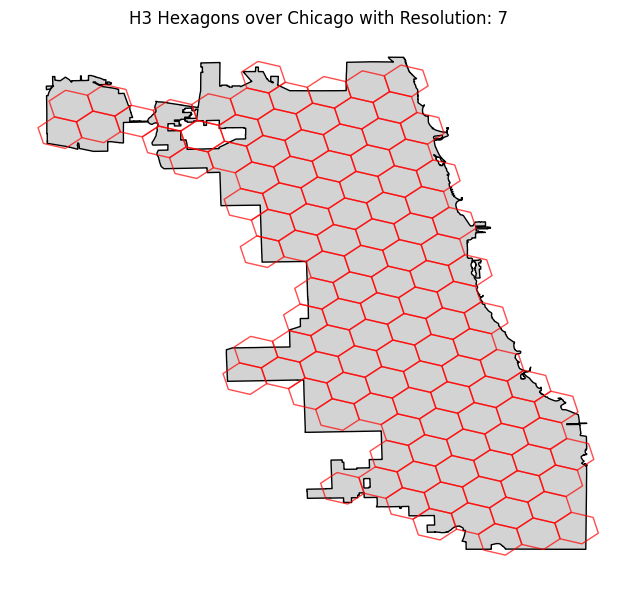

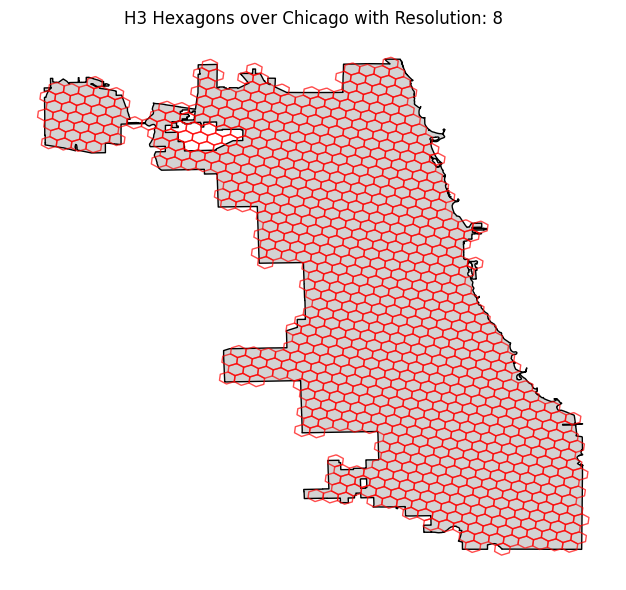

In [11]:
def compute_city_hexagons(resolution, city_poly):
    multipolygon_obj = city_poly["geometry"]
    hexagons = []

    # Iterate over each polygon within the multipolygon
    for polygon_obj in multipolygon_obj["coordinates"]:
        # Create a GeoJSON dictionary with the polygon coordinates
        geojson = {
            "type": "Polygon",
            "coordinates": [polygon_obj[0]]
        }

        # Perform polyfill operation on the individual polygon
        hexagons.extend(h3.polyfill(geojson, res=resolution, geo_json_conformant=True))

    # Convert H3 Indexes to Geometry Objects
    df_hex = gpd.GeoDataFrame(list(hexagons), columns=['h3_hex_id'])
    df_hex['geometry'] = df_hex[(df_hex['h3_hex_id'].notna())].apply(
        lambda row: shape({
            "type": "Polygon",
            "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_id"], geo_json=True)],
            "properties": ""
        }), axis=1)

    # Plot with title
    fig, ax = plt.subplots(figsize=(8,6))

    # Plot city boundary in the background with a light shade
    city.plot(ax=ax, color='lightgray', edgecolor='k')

    # Plot hexagons on top
    df_hex.plot(ax=ax, edgecolor="r", facecolor="none", alpha=0.7)

    ax.set_title(f"H3 Hexagons over Chicago with Resolution: {resolution}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for res in [6, 7, 8]:
    compute_city_hexagons(res, city_poly)


## Assigning Trips to H3 Hexagons

Having decided on the hexagon resolutions, we now add the corresponding hexagon cells for the different resolutions to each trip's start location.

In [12]:
def get_h3_index(row, resolution):
    return h3.geo_to_h3(row['start_lat'], row['start_long'], resolution)

def process_chunk(chunk):
    chunk['h3_hex_6'] = chunk.apply(lambda row: get_h3_index(row, 6), axis=1)
    chunk['h3_hex_7'] = chunk.apply(lambda row: get_h3_index(row, 7), axis=1)
    chunk['h3_hex_8'] = chunk.apply(lambda row: get_h3_index(row, 8), axis=1)
    return chunk

CHUNK_SIZE = 100000
chunks = np.array_split(df_trips, len(df_trips) // CHUNK_SIZE + 1)

processed_dataframes = []

for index, chunk in enumerate(chunks, start=1):
    processed_dataframes.append(process_chunk(chunk))
    clear_output(wait=True)
    display(f"Processed {index}/{len(chunks)} chunks")

df_trips = pd.concat(processed_dataframes)


del chunks, processed_dataframes
gc.collect()


'Processed 65/65 chunks'

0

## Column Rearrangement
Order columns logically, ensuring related columns are adjacent.


In [14]:
# Rearrange columns
df_trips = df_trips[[
    'trip_id', 'taxi_id',
    'start_time', 'end_time', 'duration', 'distance', 'hour', 'day', 'week_day', 'part_of_day', 'is_weekend', 'month',
    'start_location', 'start_lat', 'start_long', 'end_location', 'end_lat', 'end_long',
    'h3_hex_6', 'h3_hex_7', 'h3_hex_8',
    'start_census_tract', 'end_census_tract',
    'fare', 'extras', 'tips', 'tolls', 'trip_total', 'cost_per_minute', 'cost_per_km',
    'company', 'payment_type',
    'poi_count_start', 'poi_count_end',
    'airport_trip', 'is_special_date', 'is_holiday'
]]

df_trips.head()  # Displaying top rows for verification


,trip_id,taxi_id,start_time,end_time,duration,distance,hour,day,week_day,part_of_day,...,trip_total,cost_per_minute,cost_per_km,company,payment_type,poi_count_start,poi_count_end,airport_trip,is_special_date,is_holiday
0,3e9d8cc29f55f4f2b35b48cf912c023b7531fc40,a29bd1a1911d3e1c9d1493ded2b6ffc5bb87dd64944020...,2013-01-01,2013-01-01 00:15:00,720.0,4.184294,0,2013-01-01,1,Early Morning,...,9.45,0.013125,2.258445,Northwest Management LLC,Cash,1.0,2.0,0,0,1
1,0f63007e437d589c9139acb026f03a832da3240f,0aeba5363032eea4da934ccd44dde715dce7305a792531...,2013-01-01,2013-01-01 00:15:00,480.0,2.414016,0,2013-01-01,1,Early Morning,...,7.65,0.013854,2.754746,Northwest Management LLC,Cash,1.0,3.0,0,0,1
2,2330f00083ab438db5839d3949fff9954513cb77,1eaef5df745de5ff990139aa7cce76faffa732d4579cac...,2013-01-01,2013-01-01 00:15:00,540.0,3.057754,0,2013-01-01,1,Early Morning,...,8.65,0.014167,2.501837,Dispatch Taxi Affiliation,Cash,0.0,1.0,0,0,1
3,cc83914c6a72d6f861d5be744332d41e120dfdca,325a58f0fa1e439b2b733651dac2847dab175253ed4652...,2013-01-01,2013-01-01 00:15:00,240.0,1.126541,0,2013-01-01,1,Early Morning,...,10.35,0.020208,4.305215,Northwest Management LLC,Credit Card,10.0,5.0,0,0,1
4,dc843ad6e036c84b081368998db84227d47e159c,1a30531bb84733fd77ff82bc683753286ceedaae406d2b...,2013-01-01,2013-01-01 00:15:00,600.0,2.574950,0,2013-01-01,1,Early Morning,...,10.05,0.015083,3.514631,Dispatch Taxi Affiliation,Cash,6.0,2.0,0,0,1


## Saving the Engineered Features

Throughout this notebook, we've significantly transformed and extended our dataset by:
1. **Adding Distance Features**: Calculated using the Haversine formula.
2. **Adding POI Count Features**: Counting points of interest near start and end locations.
3. **Identifying Airport Trips**: Labeling trips starting or ending at airport locations.
4. **Highlighting Special Dates**: Marking trips happening on holidays or special events.
5. **Extracting Temporal Features**: Extracting hours, days, weekends, and parts of the day.
6. **Fare Efficiency Features**: Calculating cost per minute and cost per kilometer for trips.
7. **H3-Uber Discretization**: Dividing the city using hexagonal grids for spatial analysis.
8. **Assigning Trips to H3 Hexagons**: Assigning each trip's start location to a hexagon.
9. **Column Rearrangement**: Logically ordering columns for ease of interpretation.

These feature engineering tasks have equipped our dataset for more sophisticated and insightful analyses. To secure this enhanced dataset and expedite future analyses, we'll serialize the dataframe and save it as a pickle file. Pickle files maintain the data type of each column, offering efficient storage and swift read-write operations.


In [15]:
# Display final information of the DataFrame
df_trips.info()

# Define the path for the pickle file
output_pickle_path = '/content/drive/MyDrive/3A23/Data/trips_2013_extended.pkl'

# Save the enhanced DataFrame as a Pickle file
with open(output_pickle_path, 'wb') as file:
    pickle.dump(df_trips, file)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6448673 entries, 0 to 6448672
Data columns (total 37 columns):
 #   Column              Dtype         
---  ------              -----         
 0   trip_id             object        
 1   taxi_id             object        
 2   start_time          datetime64[ns]
 3   end_time            datetime64[ns]
 4   duration            float64       
 5   distance            float64       
 6   hour                int64         
 7   day                 object        
 8   week_day            int64         
 9   part_of_day         object        
 10  is_weekend          int64         
 11  month               int64         
 12  start_location      object        
 13  start_lat           float64       
 14  start_long          float64       
 15  end_location        object        
 16  end_lat             float64       
 17  end_long            float64       
 18  h3_hex_6            object        
 19  h3_hex_7            object        
 20  h3